In [3]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from tqdm import tqdm
from scipy import ndimage

In [4]:
import torch.nn.functional as F
import torch as tc
from helpers_img import *
from NeuralNets import *
from training_NN import *

# Valerio inizia da qui

In [5]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
N = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(N) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(N)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(N) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(N)]
print(files[0])

#n = 85 # Only use 85 images for training

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


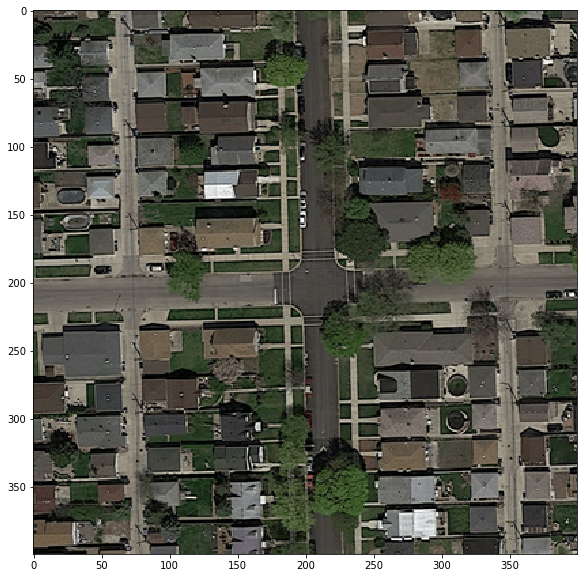

In [6]:
image = imgs[0]
plt.figure(figsize=(10,10))
plt.imshow(image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


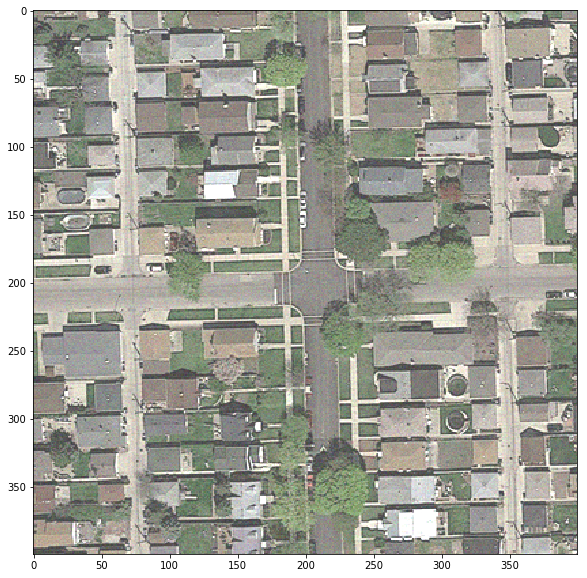

In [7]:
mean = image.mean()
std = image.std()

noise = np.random.normal(mean,std/5,size = image.shape)
image_noise = image + noise
plt.figure(figsize=(10,10))
plt.imshow(image_noise)

In [8]:
# augment the dataset adding rotated images
imgs, gt_imgs = rotation(imgs, gt_imgs)
print('Total number of imgages: '+str(len(imgs)))

Total number of imgages: 400


In [ ]:
def bootstrap_images(imgs, gt_imgs,size,number):
    '''This function returns a list of list. Each element of the "external" list is a list of randomly 
    sampled images with replacement'''
    
    new_imgs=[]
    new_gt_imgs=[]
    array = np.arange(len(imgs))
    matrix= np.zeros((len(imgs),number))
    for k in range(number):
        b = np.random.choice(array, size, replace=True)
        list_temp_imgs = [imgs[i] for i in b]
        list_temp_gt_imgs = [gt_imgs[i] for i in b]
        new_imgs.append(list_temp_imgs)
        new_gt_imgs.append(list_temp_gt_imgs)
        matrix[b,k]=1
    
    return new_imgs,new_gt_imgs,matrix

In [ ]:
? np.ndarray

In [ ]:
def train_SimpleNet(dataset, label, w, h, lr, max_epochs, mini_batch_size, dropout):
    ''' Train a simple net'''
    n = len(dataset)
    train_sub_images = [img_crop(dataset[i], w, h) for i in range(n)]
    train_mask_label = [img_crop(label[i],w,h) for i in range(n)]
    train_mask_label = from_mask_to_vector(train_mask_label,0.3)
    train_sub_images = transform_subIMG_to_Tensor(train_sub_images)
    mean = train_sub_images.mean()
    std = train_sub_images.std()
    train_sub_images = (train_sub_images-mean)/std
    train_sub_images, train_mask_label = reduce_dataset(train_sub_images,train_mask_label)
    # shuffle images
    for l in range(10):
        new_indices= np.random.permutation(len(train_mask_label))
        train_sub_images=train_sub_images[new_indices]
        train_mask_label=train_mask_label[new_indices]
    
    model = SimpleNet(dropout)
    

    train_model_Adam( model, train_sub_images, train_mask_label, max_epochs, lr, mini_batch_size)
    
    return model



In [ ]:
def bagging_NN(dataset, label, percentage_train_data, nb_model, w, h, lr, max_epochs, mini_batch_size, dropout):
    nb_data = int( len(dataset)*percentage_train_data )
    list_dataset, list_label, data_matrix = bootstrap_images(dataset, label, nb_data, nb_model)
    models = []
    for i in range(nb_model):
        model=train_SimpleNet(list_dataset[i], list_label[i], w, h, lr, max_epochs, mini_batch_size, dropout)
        models.append(model)
        print('model '+str(i)+' trained')
        
    data_matrix = 1 - data_matrix
    # the data matrix has 1 in position n,j if the nth image was not used in jth
    # model training.
    
    # compute F1 error
    
    test_imgs=[img_crop(dataset[k], w, h) for k in range(len(dataset))]
    nb_patches=len(test_imgs[0])
    test_imgs = transform_subIMG_to_Tensor(test_imgs)
    F1_error=0
    not_testable_img=0
    for i in range(len(dataset)):
        image= test_imgs.narrow(0,i*nb_patches,nb_patches)
        if data_matrix[i,:].sum()>0:
            ind=np.where(data_matrix[i,:])[0]
            predictions=[models[k](image).detach().numpy() for k in ind]
            predictions = np.array(predictions)
            predictions = predictions.mean(0)[:] >0.5
            mask_test = label_to_img(400, 400, w, h, predictions)
            F1_error += calcul_F1(label[i], mask_test)
        else:
            not_testable_img+=1
    
    F1_error= F1_error/(len(dataset)-not_testable_img)
    return models, F1_error
    

In [ ]:
# valerio modifica questo
percentage_train_data=0.05
nb_model=2
w=16
h=16
lr=1e-4
max_epochs=2
mini_batch_size=1
dropout=0
models, F1_error= bagging_NN(imgs, gt_imgs, percentage_train_data, nb_model, w, h, lr, max_epochs, mini_batch_size, dropout)

In [ ]:
a=np.array([[0,0],[0,1]])
ind= np.where(a[1,:])
print(ind)

# Valerio fermati qui

In [ ]:
a = tc.tensor([0,1])


# The U-Net

In [ ]:
? tc.nn.Module

In [9]:
class UNet(tc.nn.Module):
    def __init__(self,features=3):
        super(UNet,self).__init__()
        self.is_training=False
        self.conv1 = tc.nn.Conv2d(features,8,kernel_size=3)
        self.batch1 = tc.nn.BatchNorm2d(8)
        self.conv2 = tc.nn.Conv2d(8,8, kernel_size=3)
        self.batch2 = tc.nn.BatchNorm2d(8)
        self.conv3 = tc.nn.Conv2d(8,16, kernel_size=3)
        self.batch3 = tc.nn.BatchNorm2d(16)
        self.conv4 = tc.nn.Conv2d(16,16, kernel_size=3)
        self.batch4 = tc.nn.BatchNorm2d(16)
        self.conv5 = tc.nn.Conv2d(16,16, kernel_size=4)
        self.batch5 = tc.nn.BatchNorm2d(16)
        self.convUp1 = tc.nn.ConvTranspose2d(16,16,stride=2,kernel_size=2)
        self.conv6 = tc.nn.Conv2d(32,16, kernel_size=3)
        self.batch6 = tc.nn.BatchNorm2d(16)
        self.conv7 = tc.nn.Conv2d(16,16, kernel_size=3)
        self.batch7 = tc.nn.BatchNorm2d(16)
        self.convUp2 = tc.nn.ConvTranspose2d(16,8,stride=2,kernel_size=2)
        self.conv8 = tc.nn.Conv2d(16,8, kernel_size=3)
        self.batch8 = tc.nn.BatchNorm2d(8)
        self.conv9 = tc.nn.Conv2d(8,8, kernel_size=3)
        self.batch9 = tc.nn.BatchNorm2d(8)
        self.convUp3 = tc.nn.ConvTranspose2d(8,4,kernel_size=39)
        self.conv10 = tc.nn.Conv2d(4,1,kernel_size=3)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.batch1(x)
        x = F.relu(self.conv2(x))
        #x1 = x.clone()
        x1 = x
        x = F.max_pool2d(x, kernel_size=2)
        x = x = self.batch2(x)
        x = F.relu(self.conv3(x))
        x = self.batch3(x)
        x = F.relu(self.conv4(x))
        #x2 = x.clone()
        x2 = x
        x = F.max_pool2d(x, kernel_size=2)
        x = self.batch4(x)
        x = F.relu(self.conv5(x))
        x = self.batch5(x)
        
        x = F.relu(self.convUp1(x))
        x2= x2.narrow(2,3,188)
        x2 = x2.narrow(3,3,188)
        x= tc.cat((x,x2),dim=1)
        x = F.relu(self.conv6(x))
        x = self.batch6(x)
        x = F.relu(self.conv7(x))
        x = self.batch7(x)
        
        x = F.relu(self.convUp2(x))
        x1 = x1.narrow(2,14,368)
        x1 = x1.narrow(3,14,368)
        x = tc.cat((x1,x),dim=1)
        x = F.relu(self.conv8(x))
        x = self.batch8(x)
        x = F.relu(self.conv9(x))
        x = self.batch9(x)
        
        x = F.relu(self.convUp3(x))
        x = tc.sigmoid(self.conv10(x))
        
        return x
        
        
        
                                   
        
        

In [ ]:
? tc.sigmoid

In [ ]:
? np.random.normal

In [10]:
def add_noise(dataset,label, is_simple=True):
    '''Add noise to the dataset.
    
    dataset : tensor type
    
    label : tensor type'''
    
    
    if is_simple:
        
        mean, std = dataset.mean(), dataset.std()
        # the noise has the 20% of the image standard deviation
        noise = np.random.normal(loc = mean, scale = std/5, size = dataset.size())

        dataset_with_noise = dataset + tc.tensor(noise)
        dataset = tc.cat((dataset,dataset_with_noise),dim = 0)
        label = tc.cat((label, label), dim = 0)
    else:
        
        mean, std = 0, 0.05
        
        noise = np.random.normal(mean, std, size = label.size())
        
        label_with_noise = label + tc.tensor(noise)
        
        label = tc.cat((label,label_with_noise),dim=0)
        
        dataset = tc.cat((dataset,dataset),dim=0)
    
    return dataset, label
        
        
    
    

In [11]:
def from_list_to_tensor(dataset):
    ''' cast a list of image in a tensor of appropriate size'''
    dataset = np.array(dataset)
    try :
        N,rows,columns,features = dataset.shape
    except:
        N,rows,columns = dataset.shape
        features=1
        dataset=dataset.reshape(N,rows,columns,features)
        
    dataset_tensor = tc.Tensor(N, features, rows, columns)
    for j in range(N):
        dataset_tensor[j] = tc.tensor(np.array([dataset[j,:,:,i] for i in range(features)]))
    
    
    return dataset_tensor

In [12]:
def train_UNet(dataset, label, lr, max_epochs, mini_batch_size, nb_test, threshold=0.5):
    ''' train the UNet using the Binary Cross Entropy loss and Adam as optimizer.
    The dataset must be a list of 400*400 images.'''
    dataset = from_list_to_tensor(dataset)
    mean = dataset.mean()
    std = dataset.std()
    dataset = (dataset - mean)/ std
    test= dataset.narrow(0,dataset.size(0)-nb_test,nb_test)
    dataset = dataset.narrow(0,0,dataset.size(0)-nb_test)
    label = from_list_to_tensor(label)
    test_l = label.narrow(0,dataset.size(0)-nb_test,nb_test)
    label = label.narrow(0,0,dataset.size(0)-nb_test)
    
    ## add is_simple = False to add noise to labels
    dataset, label = add_noise(dataset, label)
    model = UNet()
    
    optimizer=tc.optim.Adam(model.parameters(),lr)
    # maybe using MSE is better
    #criterion= tc.nn.BCELoss()
    criterion = tc.nn.MSELoss()
    training_errors=[]
    losses=[]
    
    if tc.cuda.is_available():
        print('cuda is available')
        model.cuda()
        #criterion.cuda()
        test = test.cuda()
        #dataset= dataset.cuda()
        #label = label.cuda()
    
    #training_F1_error=[]
    #print('starting to train the net')
    for epoch in tqdm(range(max_epochs)):
        model.train()
        #if tc.cuda.is_available():
        #    model.cuda()
        for j in range(0,dataset.size(0)-nb_test,mini_batch_size):
            input_data = dataset.narrow(0,j,mini_batch_size)
            label_data = label.narrow(0,j,mini_batch_size)
            if tc.cuda.is_available():
                input_data, label_data = input_data.cuda(), label_data.cuda()
            output = model(input_data)
            #print(output, label_data)
            loss = criterion(output, label_data)
            model.zero_grad()
            loss.backward()
            optimizer.step()
            tc.cuda.empty_cache()
            
        
        # compute training error
        model.eval()
        losses.append(loss)
        prediction = model(test)
        prediction = prediction.cpu()
        prediction = prediction.detach_().numpy()[:,0,:,:]
        prediction = (prediction > threshold)*1
        #print(prediction[0])
        mask = test_l.numpy()[:,0,:,:]
        F1_error = 0
        #print(mask.shape)
        training_error = (((mask>0.5)*1 == prediction)*1).sum()/np.prod(prediction.shape)
        
        training_errors.append(training_error)
        
        
        # improve the calcul_F1 fonction to optimize the code
        '''
        for i in range(dataset.size(0)):
            F1_error += calcul_F1(mask[i], prediction[i])
        F1_error = F1_error/dataset.size(0)
        training_F1_error.append(F1_error)
        if F1_error >0.95:
            break
        
    # plot the results
    
    plt.figure()
    plt.plot(np.arange(epoch + 1)+1,training_F1_error)
    plt.xlabel('epoch')
    plt.ylabel('F1_error')
    '''
    plt.figure()
    plt.plot(np.arange(epoch + 1)+1,losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.figure()
    plt.plot(np.arange(epoch + 1)+1,training_errors)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    return model
        
    

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset


In [ ]:
? DataLoader

In [13]:
tc.cuda.empty_cache()

In [14]:
N = len(imgs)
n = 400
train_imgs=imgs[0:n]
train_mask=gt_imgs[0:n]
#test_imgs=imgs[n:N]
#test_mask = gt_imgs[n:N]
lr = 1e-4
max_epochs = 15
mini_batch_size=10
print('let\'s start to train the Net')
model = train_UNet(train_imgs, train_mask, lr, max_epochs, mini_batch_size,10)


let's start to train the Net


RuntimeError: Expected object of type torch.FloatTensor but found type torch.DoubleTensor for argument #3 'other'

In [ ]:
? np.prod

In [ ]:
# test on a image
image = [imgs[20]]
image = from_list_to_tensor(image)
image = (image - image.mean())/image.std()
prediction = model(image)
prediction =  prediction.detach_().numpy()[0,0,:,:]
prediction = (prediction > 0.5)*1
#mask = gt_imgs[20]
mask = prediction
image = make_img_overlay(imgs[20], mask)

plt.figure(figsize=(10,10))
plt.imshow(image)







In [ ]:
n=90*3
N=len(imgs)
train_imgs=imgs[0:n]
train_mask=gt_imgs[0:n]
test_imgs=imgs[n:N]
test_mask = gt_imgs[n:N]


In [ ]:
temp=concatenate_images(train_imgs[3], train_mask[3])
plt.figure(figsize=(10, 10))
plt.imshow(temp)

In [ ]:
? tc.nn.Dropout

In [ ]:
print(len(train_mask))

In [ ]:
print(len(test_imgs),N-n)

In [ ]:
# prepare input data 
w=16
h=16
train_sub_images=[img_crop(train_imgs[i], w, h) for i in range(n)]
train_mask_label=[img_crop(train_mask[i],w,h) for i in range(n)]
train_mask_label=from_mask_to_vector(train_mask_label,0.3)
test_sub_images=[img_crop(test_imgs[i], w, h) for i in range(N-n)]
#test_mask_label=[img_crop(train_mask[n+i],w,h) for i in range(n)]
#test_mask_label=from_mask_to_vector(test_mask_label)


In [ ]:
print((1*train_mask_label).sum()/len(train_mask_label))

In [ ]:
print(len(train_sub_images[0]))

In [ ]:
train_sub_images = transform_subIMG_to_Tensor(train_sub_images)
test_sub_images = transform_subIMG_to_Tensor(test_sub_images)

In [ ]:
# normalize data
mean = train_sub_images.mean()
std = train_sub_images.std()
train_sub_images = (train_sub_images-mean)/std
train_sub_images, train_mask_label = reduce_dataset(train_sub_images,train_mask_label)
#print(train_sub_images[-1]-train_sub_images[-2])
for l in range(n):
    new_indices= np.random.permutation(len(train_mask_label))
    train_sub_images=train_sub_images[new_indices]
    train_mask_label=train_mask_label[new_indices]
#print(train_sub_images[0]-train_sub_images[1])
#train_sub_images.requires_grad_(True)

In [ ]:
 ? tc.Tensor.narrow

In [ ]:
print(train_mask_label.sum()/len(train_mask_label))

In [ ]:
model = SimpleNet(0)
lr=1e-4
max_epochs=15
mini_batch_size=1

train_model_Adam( model, train_sub_images, train_mask_label, max_epochs, lr, mini_batch_size)

In [ ]:
print(tc.__version__)

In [ ]:
? tc.mean

In [ ]:
N1=625

In [ ]:
# print the result on a single image
#N1=int(train_sub_images.size(0)/n)
image_test= test_sub_images.narrow(0,43*N1,N1)
image_test=(image_test-mean)/std
mask_array=model(image_test)
#print(mask_array.max())
mask_list=mask_array[:]>0.5
mask_test = label_to_img(400, 400, 16, 16, mask_list)

In [ ]:
# compute F1 score
mask=gt_imgs[n]
#print(mask.sum())
print(calcul_F1(mask, mask_test))

In [ ]:
# overlap images

print_img = make_img_overlay(imgs[n+43], mask_test)
#print_img = make_img_overlay(imgs[n+43], gt_imgs[n+43])
plt.figure(figsize=(10, 10))
plt.imshow(print_img)

In [ ]:
def compute_test_error(test_dataset, test_label, nb_patches, model):
    ''' compute the F1 error made during road segmentation. 
    Exemple: for a 16*16 patch we have that nb_patches=625'''
    model.is_train=False
    mean=test_dataset.mean()
    std= test_dataset.std()
    test_dataset = (test_dataset-mean)/std
    test_output = model(test_dataset)
    w = int(400/np.sqrt(nb_patches))
    F1_error=np.zeros(int(test_dataset.size(0)/nb_patches))
    for i in range(int(test_dataset.size(0)/nb_patches)):
        mask = test_output.narrow(0,i*nb_patches, nb_patches)
        mask = mask.detach().numpy()[:]>0.5
        mask = label_to_img(400, 400, w, w, mask)
        F1_error[i] = calcul_F1(test_label[i], mask)
    plt.figure()
    plt.plot(np.arange(int(test_dataset.size(0)/nb_patches))+1,F1_error)
    plt.xlabel('image')
    plt.ylabel('F1_error')
    F1_mean= np.mean(F1_error)
    return F1_mean
    

In [ ]:
F1=compute_test_error(test_sub_images, test_mask, 625, model)

In [ ]:
print(F1)